# Deep dive into results

Analysing what the true positive rate for the predictions is.

In [1]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
import plotly.express as px

from matplotlib_venn import venn3_unweighted
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

# Load datasets

In [2]:
ecbl_df = pd.read_csv("../data/predictions/euos_ecbl_predictions.csv")
ecbl_df.head(2)

,eos,smiles,Pseudomonas_aeruginosa_activity,Pseudomonas_aeruginosa_value,Candida_auris_activity,Candida_auris_value,Enterococcus_faecalis_activity,Enterococcus_faecalis_value,Escherichia_coli_activity,Escherichia_coli_value,Aspergillus_fumigatus_activity,Aspergillus_fumigatus_value,Candida_albicans_activity,Candida_albicans_value,Staphylococcus_aureus_activity,Staphylococcus_aureus_value,mhfp6,prediction,probability
0,EOS82284,OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F,inactive,-4.11,inconclusive,63.4,inactive,-20.8,inactive,-4.91,inactive,-31.7,inactive,1.75,inactive,-0.55,[297691353 76444608 30417937 ... 84759602 ...,fungi,0.955887
1,EOS11458,COc1ccc(C(=O)Nc2ccc(C)cc2)cc1OC,inactive,-6.49,inactive,27.8,inactive,-0.5,inactive,-4.83,inactive,-25.6,inactive,-6.30,inactive,7.90,[355394601 44409534 127404489 ... 67864610 ...,fungi,0.955829


In [3]:
bioactive_df = pd.read_csv("../data/predictions/euos_biactive_predictions.csv")
bioactive_df.head(2)

,eos,smiles,Pseudomonas_aeruginosa_activity,Pseudomonas_aeruginosa_value,Candida_auris_activity,Candida_auris_value,Enterococcus_faecalis_activity,Enterococcus_faecalis_value,Escherichia_coli_activity,Escherichia_coli_value,Aspergillus_fumigatus_activity,Aspergillus_fumigatus_value,Candida_albicans_activity,Candida_albicans_value,Staphylococcus_aureus_activity,Staphylococcus_aureus_value,mhfp6,prediction,probability
0,EOS102228,Cl.Cl.NCCCCCCCCN,inactive,-6.89,inactive,12.233333,inactive,-4.7,inactive,-12.17,inactive,-17.0,inactive,-16.95,inactive,10.95,[461248215 33988699 706189559 ... 231087554 ...,acid-fast,1.000000
1,EOS100708,CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12.Cl,inactive,-0.17,active,71.800000,inactive,-22.3,inactive,-5.59,active,97.2,inconclusive,52.90,inactive,12.00,[123358859 33988699 63689098 ... 21856680 1...,fungi,0.999477


In [4]:
def get_prediction_distribution(df):
    pred_dict = {}

    for eos_id, pred in tqdm(df[["eos", "prediction"]].values):
        if pred not in pred_dict:
            pred_dict[pred] = set()
        pred_dict[pred].add(eos_id)

    fig = px.pie(
        values=[len(v) for v in pred_dict.values()],
        names=[k for k in pred_dict.keys()],
    )
    fig.show()

In [5]:
get_prediction_distribution(ecbl_df)

100%|██████████| 96092/96092 [00:00<00:00, 1903489.05it/s]


In [6]:
get_prediction_distribution(bioactive_df)

100%|██████████| 4927/4927 [00:00<00:00, 1639585.51it/s]


In [7]:
def get_activity_distribution(df, library_name, title):
    act_dict = []

    orgs = {
        "Staphylococcus_aureus": "gram-positive",
        "Pseudomonas_aeruginosa": "gram-negative",
        "Candida_auris": "fungi",
        "Enterococcus_faecalis": "gram-positive",
        "Aspergillus_fumigatus": "fungi",
        "Candida_albicans": "fungi",
        "Escherichia_coli": "gram-negative",
    }

    val_cols = [f"{col}_value" for col in orgs.keys()]

    for val, org in zip(val_cols, orgs.keys()):
        tmp = df[["eos", val]].dropna()
        tmp["activity"] = tmp[val].apply(lambda x: "Active" if x >= 50 else "Inactive")
        tmp_act_dict = tmp["activity"].value_counts().to_dict()
        tmp_act_dict["organism"] = " ".join(org.split("_"))
        tmp_act_dict["organism_type"] = orgs[org]
        act_dict.append(tmp_act_dict)

    act_df = pd.DataFrame(act_dict)
    act_df = act_df.set_index("organism")

    plt.figure(figsize=(20, 10))
    sns.barplot(
        data=act_df,
        x=act_df.index,
        y="Inactive",
        color="#e3aa00",
        label="Inactive",
        estimator=sum,
    )
    sns.barplot(
        data=act_df, x=act_df.index, y="Active", color="#638448", label="Active"
    )
    top_bar = mpatches.Patch(color="#e3aa00", label="Inactive")
    bottom_bar = mpatches.Patch(color="#638448", label="Active")
    plt.legend(handles=[top_bar, bottom_bar], fontsize=16, loc="upper right")
    plt.yscale("log")
    plt.xlabel("Pathogen", fontsize=16)
    plt.ylabel("Count", fontsize=16)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Activity distribution of {library_name} compounds", fontsize=18)
    plt.tight_layout()
    plt.savefig(f"../figures/{title}.png", dpi=400)
    plt.show()
    return act_df

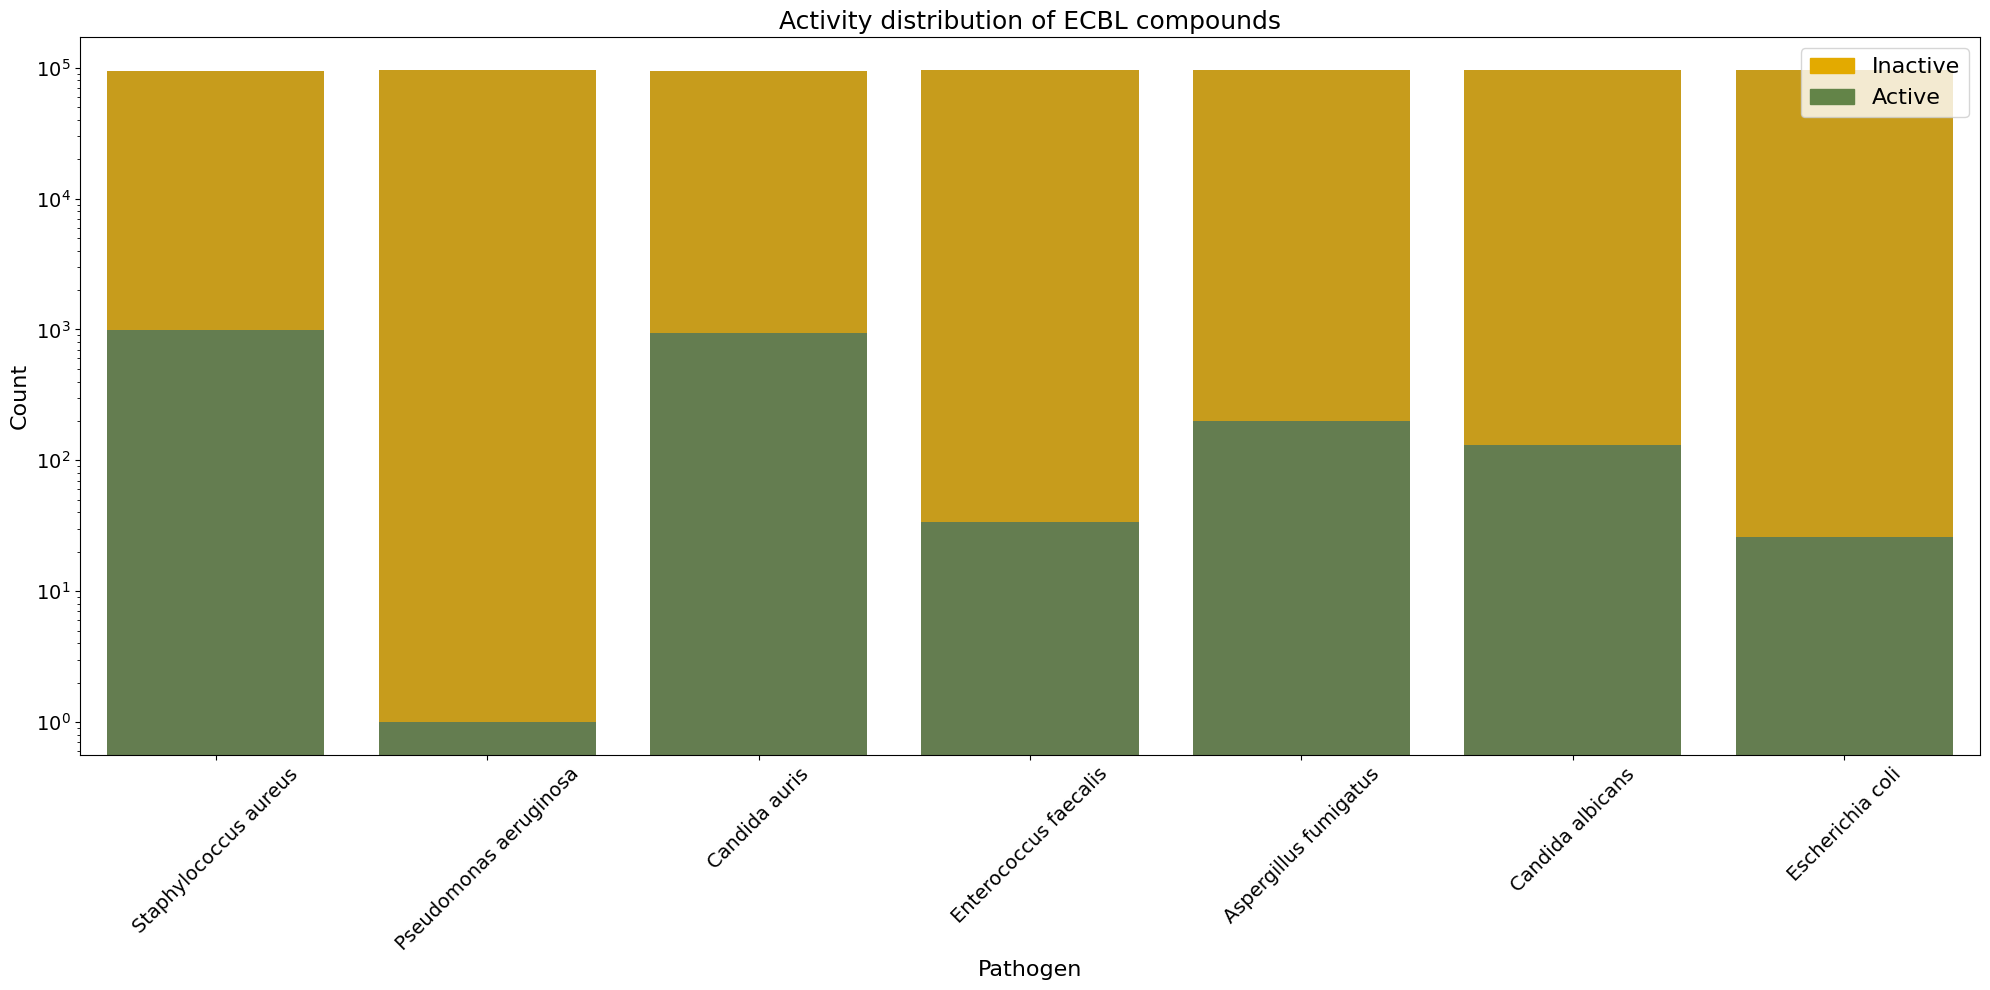

In [8]:
df_1 = get_activity_distribution(ecbl_df, title="figure_8", library_name="ECBL")

In [9]:
# normalize the values row-wise
df_1["sum"] = df_1.sum(axis=1)
df_1["Inactive"] = df_1["Inactive"].div(df_1["sum"], axis=0) * 100
df_1["Active"] = df_1["Active"].div(df_1["sum"], axis=0) * 100
df_1 = df_1.drop(columns=["sum"])
df_1.sort_values(by="organism_type")

/var/folders/x2/1tdvwk7x2_n98kzwy7rnt3t00000gn/T/ipykernel_33491/322402945.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Inactive,Active,organism_type
organism,,,
Candida auris,99.014604,0.985396,fungi
Aspergillus fumigatus,99.793866,0.206134,fungi
Candida albicans,99.863522,0.136478,fungi
Pseudomonas aeruginosa,99.998959,0.001041,gram-negative
Escherichia coli,99.972940,0.027060,gram-negative
Staphylococcus aureus,98.975359,1.024641,gram-positive
Enterococcus faecalis,99.964563,0.035437,gram-positive


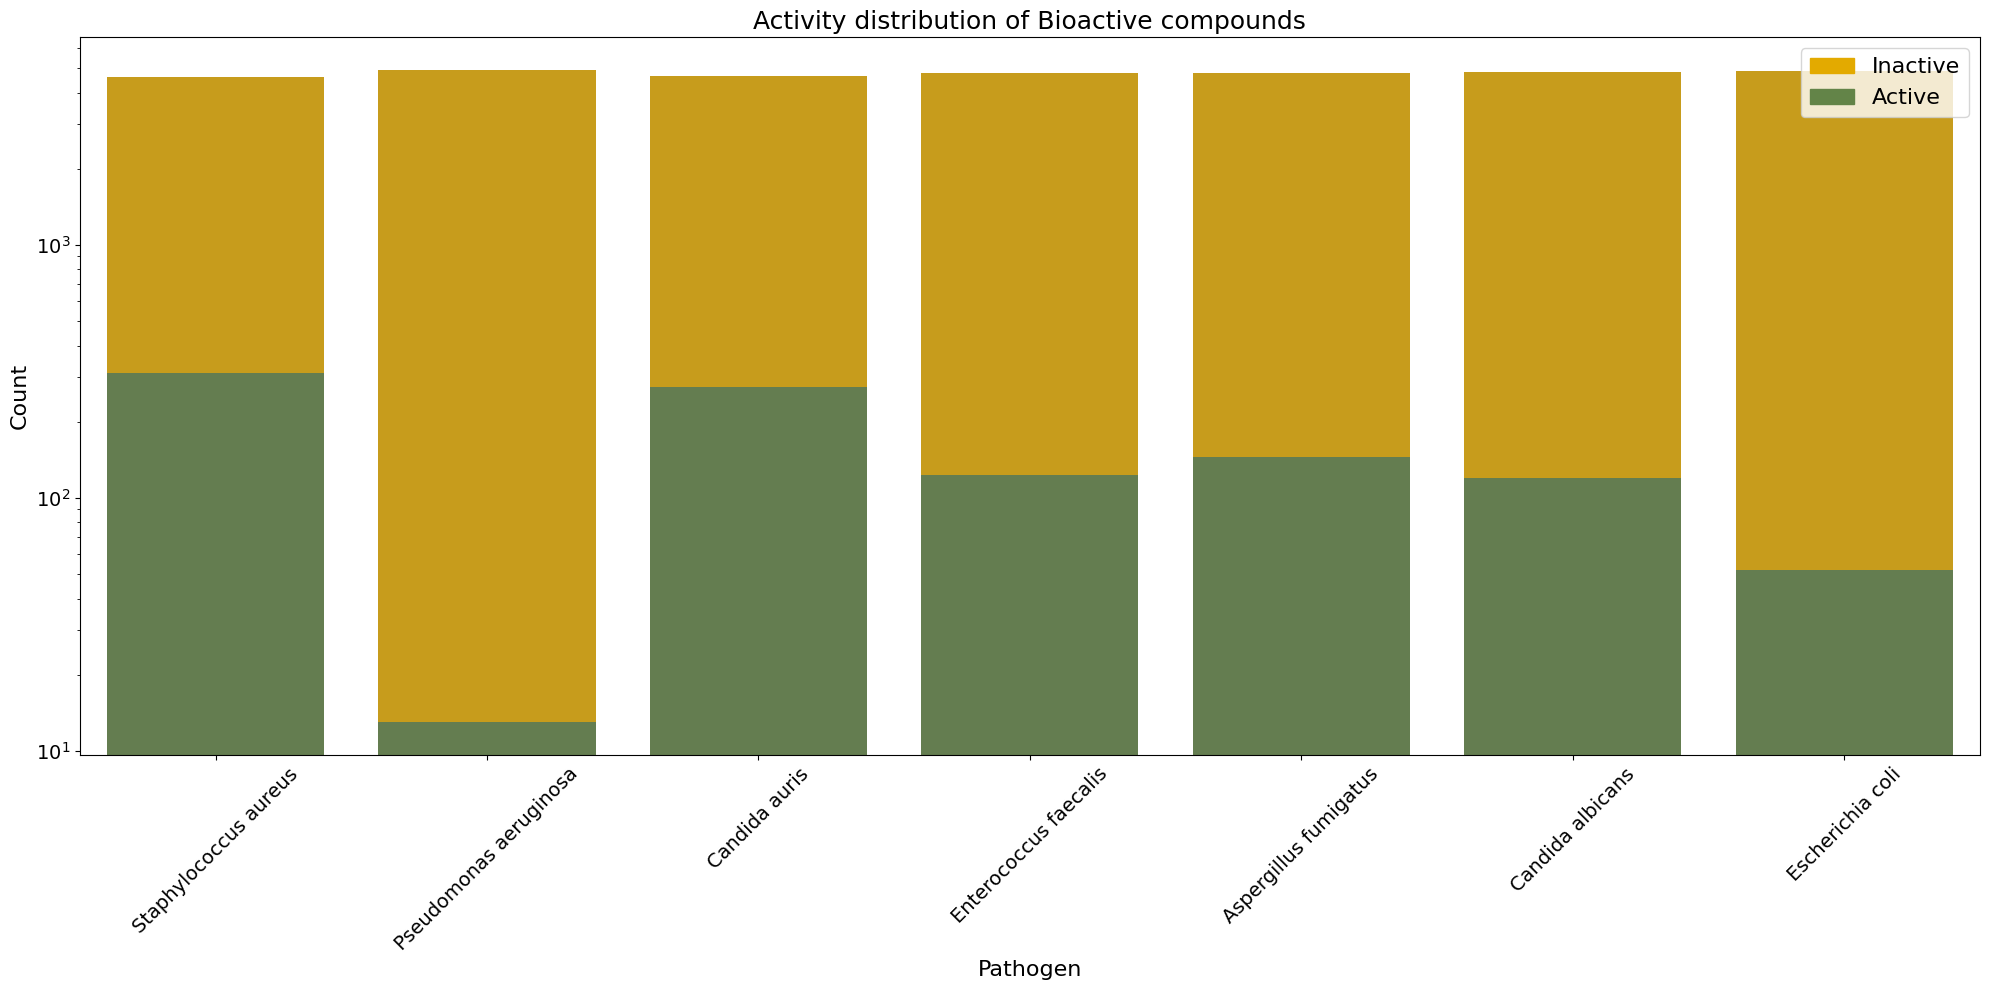

In [10]:
df_2 = get_activity_distribution(
    bioactive_df, title="figure_9", library_name="Bioactive"
)

In [11]:
# normalize the values row-wise
df_2["sum"] = df_2.sum(axis=1)
df_2["Inactive"] = df_2["Inactive"].div(df_2["sum"], axis=0) * 100
df_2["Active"] = df_2["Active"].div(df_2["sum"], axis=0) * 100
df_2 = df_2.drop(columns=["sum"])
df_2.sort_values(by="organism_type")

/var/folders/x2/1tdvwk7x2_n98kzwy7rnt3t00000gn/T/ipykernel_33491/959624910.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Inactive,Active,organism_type
organism,,,
Candida auris,94.412840,5.587160,fungi
Aspergillus fumigatus,97.055240,2.944760,fungi
Candida albicans,97.562462,2.437538,fungi
Pseudomonas aeruginosa,99.736148,0.263852,gram-negative
Escherichia coli,98.943733,1.056267,gram-negative
Staphylococcus aureus,93.647250,6.352750,gram-positive
Enterococcus faecalis,97.501016,2.498984,gram-positive


# Evaluating the prediction rate

In [12]:
def get_prediction_accuracy_all(df):
    orgs = {
        "Staphylococcus_aureus": "gram-positive",
        "Pseudomonas_aeruginosa": "gram-negative",
        "Candida_auris": "fungi",
        "Enterococcus_faecalis": "gram-positive",
        "Aspergillus_fumigatus": "fungi",
        "Candida_albicans": "fungi",
        "Escherichia_coli": "gram-negative",
    }

    val_cols = [f"{col}_value" for col in orgs.keys()]

    t = []

    for val_col_name, org in zip(val_cols, orgs):
        ecbl_subset_custom = df[[val_col_name, "prediction"]]

        # Custom thresholding for bioactive
        ecbl_subset_custom["exp_vals"] = ecbl_subset_custom[val_col_name].apply(
            lambda x: "Active" if x >= 50 else "Inactive"
        )

        # Model binary prediction
        ecbl_subset_custom["model_pred"] = ecbl_subset_custom["prediction"].apply(
            lambda x: "Active" if x == orgs[org] else "Inactive"
        )

        # Exp vals
        exp_actives = ecbl_subset_custom[
            ecbl_subset_custom["exp_vals"] == "Active"
        ].shape[0]

        # Calculate accuracy
        ecbl_subset_custom["correct"] = (
            ecbl_subset_custom["exp_vals"] == ecbl_subset_custom["model_pred"]
        )
        true_actives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        true_inactives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        false_actives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        false_inactives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        t.append(
            {
                "org": org,
                "accuracy": (
                    (true_actives + true_inactives) / ecbl_subset_custom.shape[0]
                )
                * 100,
                "true_actives": true_actives,
                "true_inactives": true_inactives,
                "false_actives": false_actives,
                "false_inactives": false_inactives,
                "tp rate": (true_actives / (true_actives + false_inactives)) * 100,
                "exp_hitrate": (exp_actives / ecbl_subset_custom.shape[0]) * 100,
            }
        )

    kk = pd.DataFrame(t)
    mean_diff = kk["tp rate"].mean() - kk["exp_hitrate"].mean()
    print(f"Mean difference: {mean_diff}")
    return kk

In [13]:
get_prediction_accuracy_all(ecbl_df)

Mean difference: 5.68552387060958


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,Staphylococcus_aureus,95.171294,41,91411,3698,942,4.170905,1.022978
1,Pseudomonas_aeruginosa,99.009283,0,95140,951,1,0.000000,0.001041
2,Candida_auris,97.520085,19,93690,1456,927,2.008457,0.984473
3,Enterococcus_faecalis,96.086043,6,92325,3733,28,17.647059,0.035383
4,Aspergillus_fumigatus,98.271448,6,94425,1469,192,3.030303,0.206053
5,Candida_albicans,98.339092,5,94491,1470,126,3.816794,0.136328
6,Escherichia_coli,98.989510,3,95118,948,23,11.538462,0.027057


In [14]:
get_prediction_accuracy_all(bioactive_df)

Mean difference: 24.891001350925126


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,Staphylococcus_aureus,85.934646,80,4154,460,233,25.559105,6.352750
1,Pseudomonas_aeruginosa,97.848589,6,4815,99,7,46.153846,0.263852
2,Candida_auris,94.134362,42,4596,56,233,15.272727,5.581490
3,Enterococcus_faecalis,88.410798,46,4310,494,77,37.398374,2.496448
4,Aspergillus_fumigatus,96.529328,36,4720,62,109,24.827586,2.942967
5,Candida_albicans,96.793180,30,4739,68,90,25.000000,2.435559
6,Escherichia_coli,97.259996,11,4781,94,41,21.153846,1.055409


In [15]:
def get_prediction_pathogen_class_wise(df):
    orgs = {
        "gram-positive": ["Staphylococcus_aureus", "Enterococcus_faecalis"],
        "gram-negative": ["Pseudomonas_aeruginosa", "Escherichia_coli"],
        "fungi": ["Candida_auris", "Aspergillus_fumigatus", "Candida_albicans"],
    }

    t = []

    for pathogen_class, col_names in orgs.items():
        val_cols = [f"{col}_value" for col in col_names]
        val_cols.append("prediction")
        ecbl_subset_custom = df[val_cols]

        exp_vals = {}

        for val_col in val_cols[:-1]:
            exp_vals[val_col] = ecbl_subset_custom[val_col].apply(
                lambda x: "Active" if x >= 50 else "Inactive"
            )  # Custom thresholding for bioactive

        exp_values = list(zip(*[v for v in exp_vals.values()]))
        final_vals = []

        for vals in exp_values:
            if "Active" in vals:
                final_vals.append("Active")
            else:
                final_vals.append("Inactive")

        ecbl_subset_custom[pathogen_class] = final_vals

        # Model binary prediction
        ecbl_subset_custom["model_pred"] = ecbl_subset_custom["prediction"].apply(
            lambda x: "Active" if x == pathogen_class else "Inactive"
        )

        # Exp vals
        exp_actives = ecbl_subset_custom[
            ecbl_subset_custom[pathogen_class] == "Active"
        ].shape[0]

        # Calculate accuracy
        ecbl_subset_custom["correct"] = (
            ecbl_subset_custom[pathogen_class] == ecbl_subset_custom["model_pred"]
        )
        true_actives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        true_inactives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        false_actives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        false_inactives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        t.append(
            {
                "class": pathogen_class,
                "accuracy": (
                    (true_actives + true_inactives) / ecbl_subset_custom.shape[0]
                )
                * 100,
                "true_actives": true_actives,
                "true_inactives": true_inactives,
                "false_actives": false_actives,
                "false_inactives": false_inactives,
                "tp rate": (true_actives / (true_actives + false_inactives)) * 100,
                "exp_hitrate": (exp_actives / ecbl_subset_custom.shape[0]) * 100,
            }
        )

    return pd.DataFrame(t)

In [16]:
get_prediction_pathogen_class_wise(ecbl_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,95.167131,41,91407,3698,946,4.154002,1.027141
1,gram-negative,98.988469,3,95117,948,24,11.111111,0.028098
2,fungi,97.380635,21,93554,1454,1063,1.937269,1.128086


In [17]:
get_prediction_pathogen_class_wise(bioactive_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,85.873757,81,4150,459,237,25.471698,6.454232
1,gram-negative,97.259996,11,4781,94,41,21.153846,1.055409
2,fungi,93.403694,45,4557,53,272,14.195584,6.433935


# Similarity with training data

In [18]:
training_df = pd.read_csv("../data/splits/combined/mhfp6_train.csv")
training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,cmp_id,label
0,14433155,9273576,52428387,55778289,29319974,24922436,192953238,62403804,49040351,48020618,...,21431025,1416250,32703087,41181622,4925637,3638752,3279595,4090642,OQZSOIHVULQZHS-CWGWECIMSA-N,gram-positive
1,19469312,71257929,14316170,121213539,115681127,75668513,127870555,119200764,327151351,164407546,...,3736543,1416250,32970732,158260114,15628711,48984996,10981154,126156214,ZGNROOOFYPKLJH-UHFFFAOYSA-N,inactive


In [19]:
bioactive_inchikeys = []

for smile in tqdm(bioactive_df["smiles"].values):
    mol = Chem.MolFromSmiles(smile)
    inchikey = Chem.inchi.MolToInchiKey(mol)
    bioactive_inchikeys.append(inchikey)

bioactive_df["inchikey"] = bioactive_inchikeys

  0%|          | 0/4927 [00:00<?, ?it/s]

100%|██████████| 4927/4927 [00:01<00:00, 3472.94it/s]


In [20]:
ecbl_inchikeys = []

for smile in tqdm(ecbl_df["smiles"].values):
    mol = Chem.MolFromSmiles(smile)
    inchikey = Chem.inchi.MolToInchiKey(mol)
    ecbl_inchikeys.append(inchikey)

ecbl_df["inchikey"] = ecbl_inchikeys

100%|██████████| 96092/96092 [00:22<00:00, 4235.52it/s]


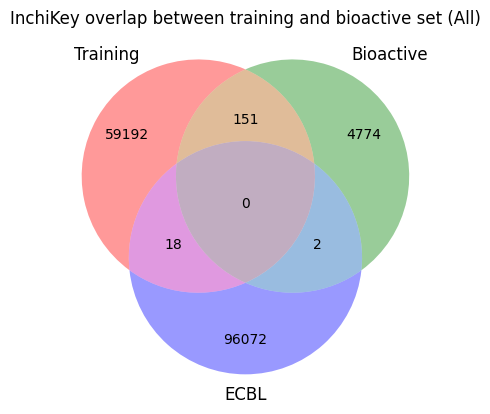

In [21]:
bioactive_inchikeys = set(bioactive_df["inchikey"].values)
training_inchikeys = set(training_df["cmp_id"].values)
ecbl_inchikeys = set(ecbl_df["inchikey"].values)

venn3_unweighted(
    [training_inchikeys, bioactive_inchikeys, ecbl_inchikeys],
    set_labels=("Training", "Bioactive", "ECBL"),
)
plt.title(f"InchiKey overlap between training and bioactive set (All)")
plt.show()

In [22]:
def plot_cmpd_overlap():
    k = []
    for strain_name in [
        "Staphylococcus_aureus",
        "Pseudomonas_aeruginosa",
        "Candida_auris",
        "Enterococcus_faecalis",
        "Aspergillus_fumigatus",
        "Candida_albicans",
        "Escherichia_coli",
    ]:
        col_name = f"{strain_name}_value"
        bioactive_inchikeys = []

        for val, inchikey in bioactive_df[[col_name, "inchikey"]].values:
            if val >= 50:
                bioactive_inchikeys.append(inchikey)

        bioactive_inchikeys = set(bioactive_inchikeys)
        training_inchikeys = set(training_df["cmp_id"].values)

        inchikeys_in_training = len(
            bioactive_inchikeys.intersection(training_inchikeys)
        )
        inchikeys_in_bioactive = len(bioactive_inchikeys.difference(training_inchikeys))

        k.append(
            {
                "strain": strain_name,
                "Found in training": inchikeys_in_training,
                "Not found in training": inchikeys_in_bioactive,
            }
        )

    df = pd.DataFrame(k)

    fig = px.bar(
        df,
        x="strain",
        y=["Found in training", "Not found in training"],
        barmode="group",
        title="InchiKey overlap between training and bioactive set (All)",
    )

    # show %age overlap on top of bars
    for i in range(len(df)):
        fig.add_annotation(
            x=df["strain"][i],
            y=df["Found in training"][i],
            text=f"{(df['Found in training'][i] / (df['Found in training'][i] + df['Not found in training'][i])) * 100:.2f}%",
            showarrow=True,
        )

    fig.show()

In [23]:
plot_cmpd_overlap()

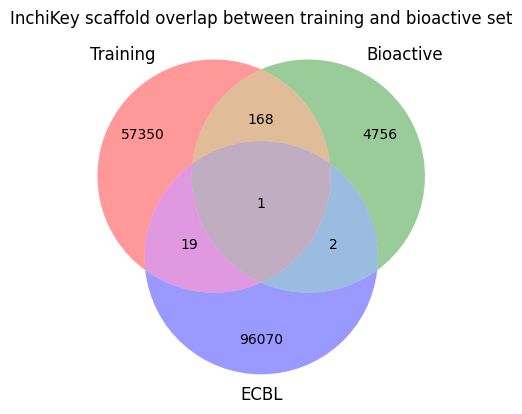

In [24]:
bioactive_scaffolds = set([i.split("-")[0] for i in bioactive_inchikeys])
training_scaffolds = set([i.split("-")[0] for i in training_inchikeys])
ecbl_scaffolds = set([i.split("-")[0] for i in ecbl_inchikeys])

venn3_unweighted(
    [training_scaffolds, bioactive_scaffolds, ecbl_scaffolds],
    set_labels=("Training", "Bioactive", "ECBL"),
)
plt.title("InchiKey scaffold overlap between training and bioactive set")
plt.show()

# Prediction probabilities after removal of training set compounds

In [25]:
bioactive_overlapped_compounds = bioactive_inchikeys.intersection(training_inchikeys)
ecbl_overlapped_compounds = ecbl_inchikeys.intersection(training_inchikeys)

In [26]:
len(bioactive_overlapped_compounds), len(ecbl_overlapped_compounds)

(151, 18)

In [27]:
ecbl_non_train_df = ecbl_df[~ecbl_df["inchikey"].isin(ecbl_overlapped_compounds)]
bioactive_non_train_df = bioactive_df[
    ~bioactive_df["inchikey"].isin(bioactive_overlapped_compounds)
]

len(ecbl_df), len(ecbl_non_train_df), len(bioactive_non_train_df), len(bioactive_df)

(96092, 96074, 4776, 4927)

In [28]:
get_prediction_accuracy_all(ecbl_non_train_df)

Mean difference: 4.99451083274408


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,Staphylococcus_aureus,95.175594,40,91399,3696,939,4.085802,1.019006
1,Pseudomonas_aeruginosa,99.014301,0,95127,946,1,0.000000,0.001041
2,Candida_auris,97.525865,16,93681,1453,924,1.702128,0.978412
3,Enterococcus_faecalis,96.087391,5,92310,3731,28,15.151515,0.034349
4,Aspergillus_fumigatus,98.276329,5,94413,1464,192,2.538071,0.205050
5,Candida_albicans,98.343985,3,94480,1466,125,2.343750,0.133231
6,Escherichia_coli,98.994525,3,95105,943,23,11.538462,0.027062


In [29]:
get_prediction_accuracy_all(bioactive_non_train_df)

Mean difference: 11.419414924825318


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,Staphylococcus_aureus,86.432161,56,4072,446,202,21.705426,5.402010
1,Pseudomonas_aeruginosa,98.136516,0,4687,83,6,0.000000,0.125628
2,Candida_auris,94.535176,18,4497,51,210,7.894737,4.773869
3,Enterococcus_faecalis,88.860972,33,4211,469,63,34.375000,2.010050
4,Aspergillus_fumigatus,97.068677,19,4617,50,90,17.431193,2.282245
5,Candida_albicans,97.194305,10,4632,59,75,11.764706,1.779732
6,Escherichia_coli,97.738693,1,4667,82,26,3.703704,0.565327


In [30]:
get_prediction_pathogen_class_wise(ecbl_non_train_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,95.171430,40,91395,3696,943,4.069176,1.023170
1,gram-negative,98.993484,3,95104,943,24,11.111111,0.028103
2,fungi,97.386390,18,93545,1451,1060,1.669759,1.122052


In [31]:
get_prediction_pathogen_class_wise(bioactive_non_train_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,86.369347,57,4068,445,206,21.673004,5.506700
1,gram-negative,97.738693,1,4667,82,26,3.703704,0.565327
2,fungi,93.907035,21,4464,48,243,7.954545,5.527638
